# Neural network lecture demo/Lab

In this demo we will use CNN to predict the orientation of a face in a 32 by 32 pixel image. The data set used is from: [Chaper 4 of Machine Learning book by Tom Mitchell](http://www.cs.cmu.edu/~tom/faces.html)

The faces of 20 different people are captured at 4 orientations: Left, Right, Up, Straight. Images from each individual is in a separate folder and the label (orientation) for a specific image is given by the image name.  `glickman_up_neutral_sunglasses.pgm -> up`

In [83]:
import tensorflow as tf
AUTOTUNE = tf.data.experimental.AUTOTUNE

import IPython.display as display
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import os

import pandas as pd

tf.__version__

'1.15.2'

## Load the dataset and prepare test train splits
Load the Face dataset. The dataset can be downloaded from canvas. You can upload it to the notebook work environment and unzip using the following code. 

In [84]:
# import zipfile
# with zipfile.ZipFile('./faces_TM.zip', 'r') as zip_ref:
#     zip_ref.extractall('./')

Split the validation-training data. A good practice would be to hold out some individuals for validation. This will eliminate possible overlaps between train/test splits. Lets hold out the last 5 individuals for testing.

In [85]:
test_persons = ['sz24', 'megak', 'night', 'choon', 'kawamura']

Iterate through the sub folders and read all the image names and create a data frame with relevant information that can be used for training and testing the MLP. 

In [86]:
from PIL import Image
import glob
image_list = []
for filepath in glob.glob('./faces_TM/*/*.jpg', recursive=True): #assuming gif
    filename = filepath.split("/")[-1]
    person = filepath.split("/")[-2]
    label = filename.split("_")[1]
    # print(filepath, person, label)
    test_train = person in test_persons
    image_list.append((filepath, label, int(test_train)))
    
# Create a data frame
data = pd.DataFrame(data=image_list, columns=['image_path', 'label', 'isTest'])

Lets plot some random images and observe

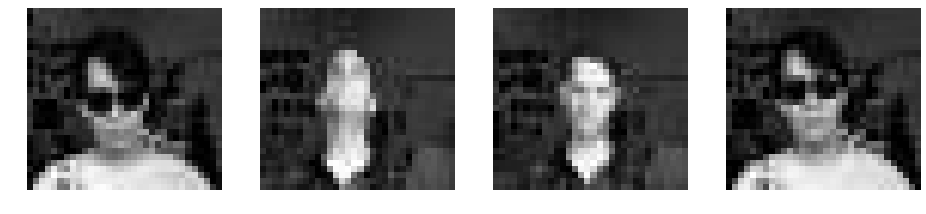

In [87]:
r_inx = np.random.choice(100, 4)
rand_data = data.loc[r_inx,'image_path']

plt.figure(figsize=(16,4))
for i, image_path in enumerate(rand_data):
    im = np.asarray(Image.open(image_path))
    plt.subplot(1,4,i+1)
    plt.imshow(im,cmap='gray')
    plt.axis('off')
    
plt.show()

Generate two data frames for training and validation

In [88]:
train_df = data[data['isTest']==0].reset_index()
validation_df = data[data['isTest']==1].reset_index()
print('Train size: {}, Test size: {}'.format(train_df.shape[0], validation_df.shape[0] ) )
N_train_images = train_df.shape[0]
N_val_images = validation_df.shape[0]

Train size: 469, Test size: 155


## Build Support functions for training and evaluation

We will follow the same procedure as last week to setup a trainin function and plot results function. 

We can use a simple model.fit\_generator() in Keras to train the model. However you will not be doing this. In order to understand the process we will write a function that iterates through the examples and train the model. First we need a function to calculate the accuracy and the loss for a given image stream. Then we will write a function to train a given model and plot the results.

In [89]:
batch_size = 16

In [90]:
def calculate_losses(model_in, data_generator_in, N_images, batch_size_):
    loss_hold = []
    acc_hold = []
    batches = 0
    
    # iterate over each batch
    for x,y in data_generator_in:
        loss, acc = model_in.evaluate(x, y, verbose=0)
        loss_hold.append(loss)
        acc_hold.append(acc)
        batches += 1
        if batches >= N_images / batch_size_:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break
            
    return np.mean(loss_hold), np.mean(acc_hold)

In [91]:
def train_model(model_, train_generator_in, validation_generator_in, num_epoch=50, verbose=False):
    res = []
    for e in range(num_epoch):
        # print('Epoch', e)
        batches = 0

        loss_ = []
        acc_ = []

         # iterate over each batch
        for x,y in train_generator_in:
            loss, acc = model_.train_on_batch(x, y) # Update weights and return train loss, acc per batch
            loss_.append(loss)
            acc_.append(acc)
            batches += 1
            if batches >= N_train_images / batch_size:
                # we need to break the loop by hand because
                # the generator loops indefinitely
                break
        loss_ = np.mean(loss_)
        acc_ = np.mean(acc_)

        loss, acc = calculate_losses(model_, validation_generator_in, N_val_images, batch_size)
        if verbose:
            print("Training epoch {}: Loss = {}, Accuracy = {}".format(e, loss_, acc_))
            print("Validation epoch {}: Loss = {}, Accuracy = {}".format(e, loss, acc))

        res.append((e, loss_, acc_, loss, acc))
    return np.asarray(res)

In [92]:
def plot_results(res):
    plt.figure(figsize=(12,4))
    plt.subplot(1,2,1)
    plt.plot(res[:,0], res[:,1], 'r-')
    plt.plot(res[:,0], res[:,3], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Loss')
    plt.ylim([0, np.max([5., np.max(res[:,1]), np.max(res[:,3])])])

    plt.subplot(1,2,2)
    plt.plot(res[:,0], res[:,2], 'r-')
    plt.plot(res[:,0], res[:,4], 'b-')
    plt.legend(['Train', 'Validation'])
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')
    plt.ylim([0, np.max([1., np.max(res[:,2]), np.max(res[:,4])])])

## Define the model and train

As are going to work with much larger and more complicated data set, that neural network are more suited towards, we need to write efficient code to load the data in batches to memory. This is done in keras using Image data generators. 

To help we will define a loading function that takes the data frames we defined earlier:

It seems that dataloader does not like to read one channel images. It automatically converts them to 3-channel images. Lets ignore this for now. 

In [93]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 469 validated image filenames belonging to 4 classes.
Found 155 validated image filenames belonging to 4 classes.


Now lets define our CNN Architecture

In [94]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Lambda, Input
from tensorflow.keras.layers import Activation, Dropout, Flatten, Dense
from tensorflow.keras.metrics import categorical_accuracy
from tensorflow.keras import regularizers, optimizers

model_cnn = Sequential()

# input
model_cnn.add(Input(shape=(28, 28, 3)))
model_cnn.add(Lambda(lambda x: tf.expand_dims(x[:,:,:,0], -1, name=None))) 
# this is a workaround. Dataloader automatically read one channel image as 3 channel 
#and we use Lambda layer to revert this back. Lambda layer can be used for operation 
#that does not involve trainianble weights

# Conv Layer 1
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# Conv Layer 2 (no pooling)
model_cnn.add(Conv2D(32, (3, 3),kernel_regularizer=regularizers.l2(0.001)))
model_cnn.add(Activation('relu'))

# Conv Layer 3
model_cnn.add(Conv2D(64, (3, 3)))
model_cnn.add(Activation('relu'))
model_cnn.add(MaxPooling2D(pool_size=(2, 2)))

# MLP
model_cnn.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model_cnn.add(Dense(64))
model_cnn.add(Activation('relu'))
model_cnn.add(Dropout(0.5))
model_cnn.add(Dense(4))
model_cnn.add(Activation('softmax'))

sgd = optimizers.SGD(lr=0.01, decay=1e-6, momentum=0.9, nesterov=True)
model_cnn.compile(loss='categorical_crossentropy',
              optimizer=sgd,
              metrics=[categorical_accuracy])

# save the weights so that we can start from the same place when tring different configurations
model_cnn.save_weights('model.h5')

model_cnn.summary()

Model: "sequential_8"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_5 (Lambda)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d_16 (Conv2D)           (None, 26, 26, 32)        320       
_________________________________________________________________
activation_25 (Activation)   (None, 26, 26, 32)        0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 13, 13, 32)        0         
_________________________________________________________________
conv2d_17 (Conv2D)           (None, 11, 11, 32)        9248      
_________________________________________________________________
activation_26 (Activation)   (None, 11, 11, 32)        0         
_________________________________________________________________
conv2d_18 (Conv2D)           (None, 9, 9, 64)         

Lets now Train the model and plot the results

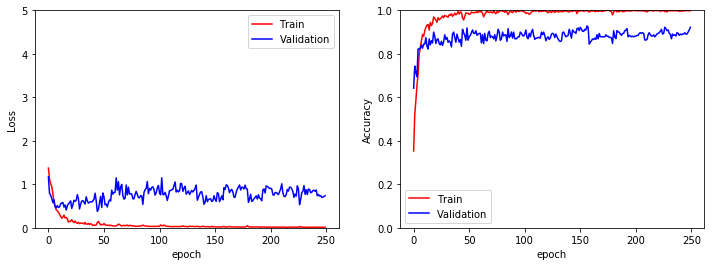

In [95]:
res = train_model(model_cnn, train_generator, validation_generator, num_epoch=250, verbose=False)
plot_results(res)

## Data Augmentation

Is the model overfitting? One important method that can be used to prevent CNN from over fitting is to augment the images randomly. The image data generator can apply random image augmentations to data like: rotations, translation etc. Lets do some random rotations and translations. Note that Augmentations are not usually applied to test data.  

In [96]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last', 
                                   rotation_range=15, width_shift_range=0.2, 
                                   height_shift_range=0.2)
val_datagen = ImageDataGenerator(rescale=1./255, data_format='channels_last')

batch_size = 16

train_generator = train_datagen.flow_from_dataframe(
        dataframe=train_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

validation_generator = val_datagen.flow_from_dataframe(
        dataframe=validation_df,
        directory='./',
        x_col="image_path",
        y_col="label",
        target_size=(28, 28),
        batch_size=batch_size,
        class_mode='categorical')

Found 469 validated image filenames belonging to 4 classes.
Found 155 validated image filenames belonging to 4 classes.


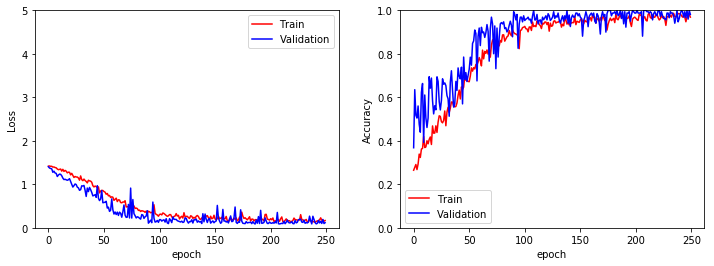

In [97]:
model_cnn.load_weights('model.h5')

res = train_model(model_cnn, train_generator, validation_generator, num_epoch=250, verbose=False)
plot_results(res)